#Step 1: Importing libraries
###Connects to Google Drive.
###Downloads the "70 Dog Breeds Image Dataset" from Kaggle.

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import kagglehub
from google.colab import drive
import os

# Conect to Google Drive
drive.mount('/content/drive')


# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)

Mounted at /content/drive


100%|██████████| 215M/215M [00:01<00:00, 154MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2


#Step 2: Data Preprocessing and Loading

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Paths to the training and testing dataset directories
train_path = "/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train"
test_path = "/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/test"

# Define the transformations for the training dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)), # Randomly crop the image to 128x128 within the given scale
    transforms.RandomHorizontalFlip(),# Randomly flip the image horizontally
    transforms.RandomRotation(10),# Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),# Adjust brightness and contrast randomly
    transforms.ToTensor(),# Convert the image to a PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalize pixel values to [-1, 1] range
])
# Define the transformations for the test dataset
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),# Resize images to 128x128
    transforms.ToTensor(),# Convert the image to a PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalize pixel values to [-1, 1] range
])
# Load the training and test dataset
train_data = datasets.ImageFolder(root=train_path, transform=train_transform)
test_data  = datasets.ImageFolder(root=test_path,  transform=test_transform)
# Create DataLoader for the training and test dataset
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)
# Print the class names and total number of classes
num_classes = len(train_data.classes)
print("Classes (breeds):", train_data.classes)
print(f"Total classes: {num_classes}")


Classes (breeds): ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']
Total classes: 70


#Step 3: Dataset Summary
###Prints the number of images in the training and test datasets.

In [ ]:
print("Train samples", len(train_data))
print("Test samples", len(test_data))



Train samples 7946
Test samples 700


## **Step 4: Defining the ResNet Model**
In this step, we implement a **ResNet18-based Convolutional Neural Network (CNN)** for **dog breed classification**.

### **Model Architecture**
- **Initial Layers:**
  - A **7x7 convolutional layer** with **stride 2**, followed by **batch normalization** and **max pooling** to reduce spatial dimensions.

- **Residual Blocks:**
  - The model consists of **four main layers**, each containing **multiple residual blocks**.
  - Each **residual block** includes:
    - **Two convolutional layers** with batch normalization and **ReLU activation**.
    - A **shortcut connection** that allows information to bypass convolutional layers, improving gradient flow and reducing the vanishing gradient problem.

- **Final Classification Layers:**
  - The feature maps pass through an **adaptive average pooling layer** to create a fixed-size tensor.
  - A **fully connected (FC) layer** maps the extracted features to **70 dog breed classes**.
  - **Dropout (0.5)** is applied before the final classification layer to prevent overfitting.

This **ResNet18 model** is optimized for **dog breed classification**, leveraging **deep residual learning** to enhance accuracy and training efficiency.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a Residual Block used in ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first conv layer

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second conv layer

        # Shortcut connection to bypass the residual block if needed
        self.shortcut = nn.Sequential()

        # If the input and output channels do not match, or stride is not 1,
        # apply a 1x1 convolution to the shortcut connection to match dimensions.
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)  # Normalize shortcut output
            )

    def forward(self, x):
        # Apply first convolution, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))

        # Apply second convolution and batch normalization (ReLU comes later)
        out = self.bn2(self.conv2(out))

        # Add the shortcut (identity connection) to the output
        out += self.shortcut(x)

        # Apply ReLU activation to the final output
        out = F.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=70):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Initial number of channels

        # Initial convolution layer with batch normalization and max pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)  # First conv layer
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after first conv layer
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Reduce spatial dimensions

        # Define four main layers with residual blocks
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)  # First ResNet block
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # Second ResNet block
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # Third ResNet block
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # Fourth ResNet block

        # Adaptive average pooling before fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduces to 1x1 feature maps

        # Fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    # Function to create multiple residual blocks in a layer
    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        # First block in the layer
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels  # Update input channels for next blocks

        # Remaining blocks in the layer (without stride)
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution, batch normalization, and activation
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.pool(out)  # Apply max pooling

        # Pass through the four ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Apply global average pooling
        out = self.avg_pool(out)

        # Flatten before passing to fully connected layer
        out = torch.flatten(out, 1)

        # Apply dropout before classification
        out = self.dropout(out)  # Dropout helps prevent overfitting

        # Final fully connected layer for classification
        out = self.fc(out)

        return out

# Function to instantiate a ResNet18 model with the defined architecture
def ResNet18(num_classes=70):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=num_classes)


Step 5: Loading, Training, and Evaluating the ResNet Model
In this step, we loaded the ResNet18 model, set up the loss function and optimizer, and trained the model while tracking performance.

Model Initialization
Model Loading: Initialized the ResNet18 model and moved it to the available device (CPU/GPU).
Loss Function: Used CrossEntropyLoss, which is suitable for multi-class classification.
Optimizer & Learning Rate Scheduler:
Used the Adam optimizer with a learning rate of 0.001.
Implemented a learning rate scheduler that reduces the LR when validation accuracy plateaus.
Training Process
Forward Pass: Passed images through the model to compute predictions.
Loss Computation: Calculated the classification loss using CrossEntropyLoss.
Backward Pass & Optimization: Updated model weights using backpropagation.
Tracking Metrics: Recorded training loss, test loss, training accuracy, and test accuracy.
Evaluation and Early Stopping
Test Set Evaluation:
Computed test accuracy and loss at the end of each epoch.
Best Model Saving:
The best-performing model (based on test accuracy) was saved to disk.
Early Stopping:
If no improvement was observed for 5 consecutive epochs, training was stopped early to prevent overfitting.
Performance Visualization
After training, we plotted graphs showing:
Loss trends for training and testing.
Accuracy progression over epochs.
This step ensures that the ResNet18 model is efficiently trained and evaluated, with mechanisms to prevent overfitting and improve performance over time.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet18 model and move it to the selected device (CPU/GPU)
model_ResNet_Architecture = ResNet18().to(device)

# Define the loss function (CrossEntropyLoss is used for multi-class classification)
criterion_ResNet = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
optimizer_ResNet = optim.Adam(model_ResNet_Architecture.parameters(), lr=0.001)

Epoch [1/50] | Train Loss: 4.1092 | Train Accuracy: 4.82% | Test Loss: 3.7102 | Test Accuracy: 9.00%
Epoch [2/50] | Train Loss: 3.7469 | Train Accuracy: 8.07% | Test Loss: 3.5174 | Test Accuracy: 11.14%
Epoch [3/50] | Train Loss: 3.5371 | Train Accuracy: 11.00% | Test Loss: 4.8286 | Test Accuracy: 7.43%
Epoch [4/50] | Train Loss: 3.3621 | Train Accuracy: 14.10% | Test Loss: 3.2138 | Test Accuracy: 16.86%
Epoch [5/50] | Train Loss: 3.1760 | Train Accuracy: 17.95% | Test Loss: 3.2777 | Test Accuracy: 14.86%
Epoch [6/50] | Train Loss: 3.0070 | Train Accuracy: 21.34% | Test Loss: 2.7395 | Test Accuracy: 25.29%
Epoch [7/50] | Train Loss: 2.8019 | Train Accuracy: 25.84% | Test Loss: 2.6751 | Test Accuracy: 28.14%
Epoch [8/50] | Train Loss: 2.6410 | Train Accuracy: 29.02% | Test Loss: 2.3333 | Test Accuracy: 35.71%
Epoch [9/50] | Train Loss: 2.4683 | Train Accuracy: 33.38% | Test Loss: 2.5008 | Test Accuracy: 32.57%
Epoch [10/50] | Train Loss: 2.2775 | Train Accuracy: 37.30% | Test Loss: 1.87

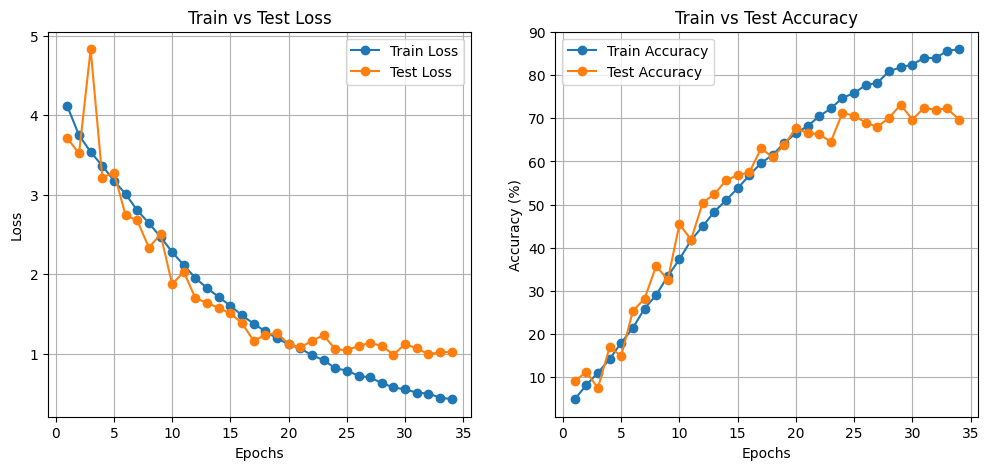

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Initialize variables for collecting data for graphs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

best_test_acc = 0
best_train_acc = 0  # Store the best model accuracy
early_stopping_triggered = False  # Flag for early stopping
early_stopping_patience = 5
epochs_without_improvement = 0

save_path = "/content/drive/MyDrive/best_model_ResNet.pth"

scheduler_ResNet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ResNet, mode='max', patience=5, factor=0.5)
num_epochs = 50

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0  # Also calculate loss for the test set
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion_ResNet(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy  # Return both loss and accuracy

for epoch in range(num_epochs):
    model_ResNet_Architecture.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_ResNet.zero_grad()
        outputs = model_ResNet_Architecture(images)
        loss = criterion_ResNet(outputs, labels)
        loss.backward()
        optimizer_ResNet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate loss and accuracy for each epoch
    epoch_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    test_loss, test_acc = evaluate_model(model_ResNet_Architecture, test_loader)  # Get both loss and accuracy

    # Save history for graphs
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    scheduler_ResNet.step(test_acc)

    # Save the best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_train_acc = train_acc
        torch.save(model_ResNet_Architecture.state_dict(), save_path)
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Print results for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Train Accuracy: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | "
          f"Test Accuracy: {test_acc:.2f}%")

    # Early stopping if no improvement
    if epochs_without_improvement >= early_stopping_patience:
        early_stopping_triggered = True
        break

# Print summary at the end of training
if early_stopping_triggered:
    print(f"Early stopping triggered after {epoch+1} epochs.")

print(f"Final Model - Train Accuracy: {best_train_acc:.2f}%, Test Accuracy: {best_test_acc:.2f}%")

# Display graphs after training
def plot_training_history(train_losses, test_losses, train_accuracies, test_accuracies):
    import matplotlib.pyplot as plt

    epochs = range(1, len(train_losses) + 1)

    # Loss graph
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, test_losses, label="Test Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.legend()
    plt.grid()

    # Accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Train vs Test Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

# Call function to display graphs
plot_training_history(train_losses, test_losses, train_accuracies, test_accuracies)


confition matrix

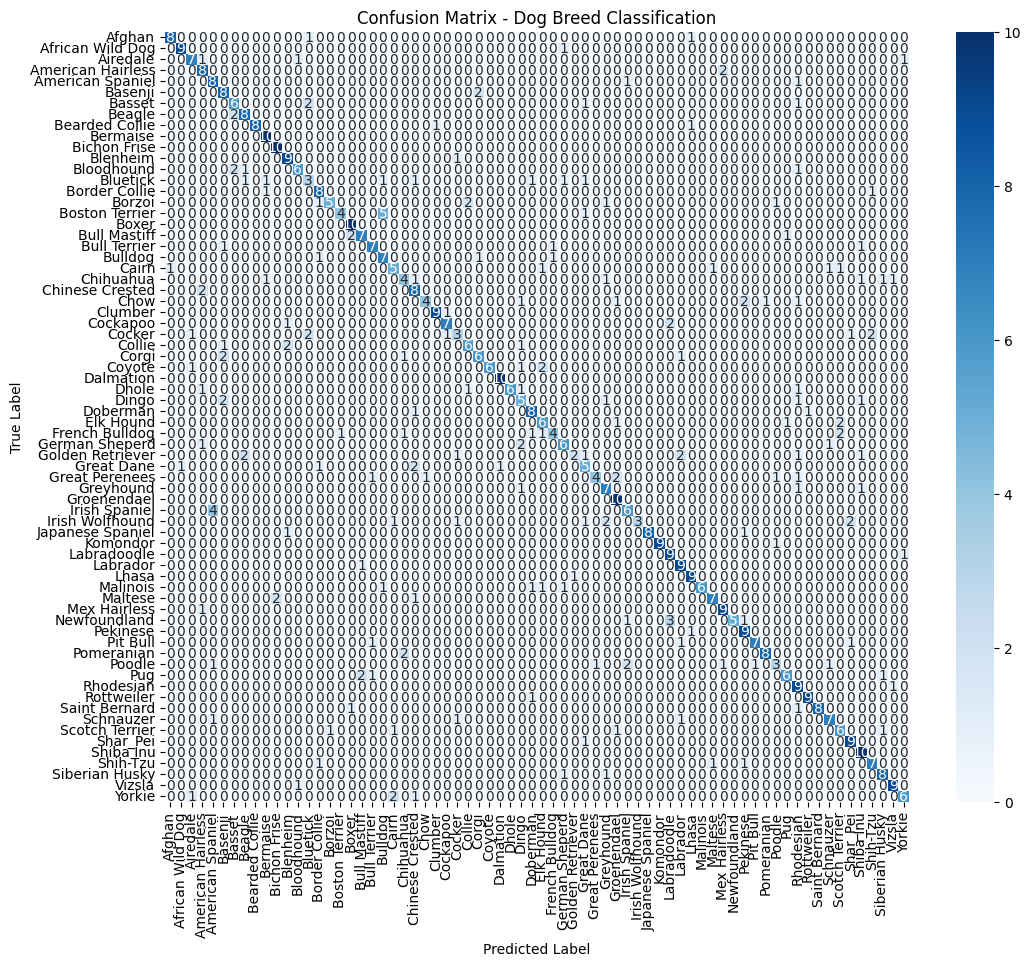

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Function to compute the confusion matrix
def compute_confusion_matrix(model, loader, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    return cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Compute and display the confusion matrix
cm = compute_confusion_matrix(model_ResNet_Architecture, test_loader, train_data.classes)
plot_confusion_matrix(cm, train_data.classes, title="Confusion Matrix - Dog Breed Classification")


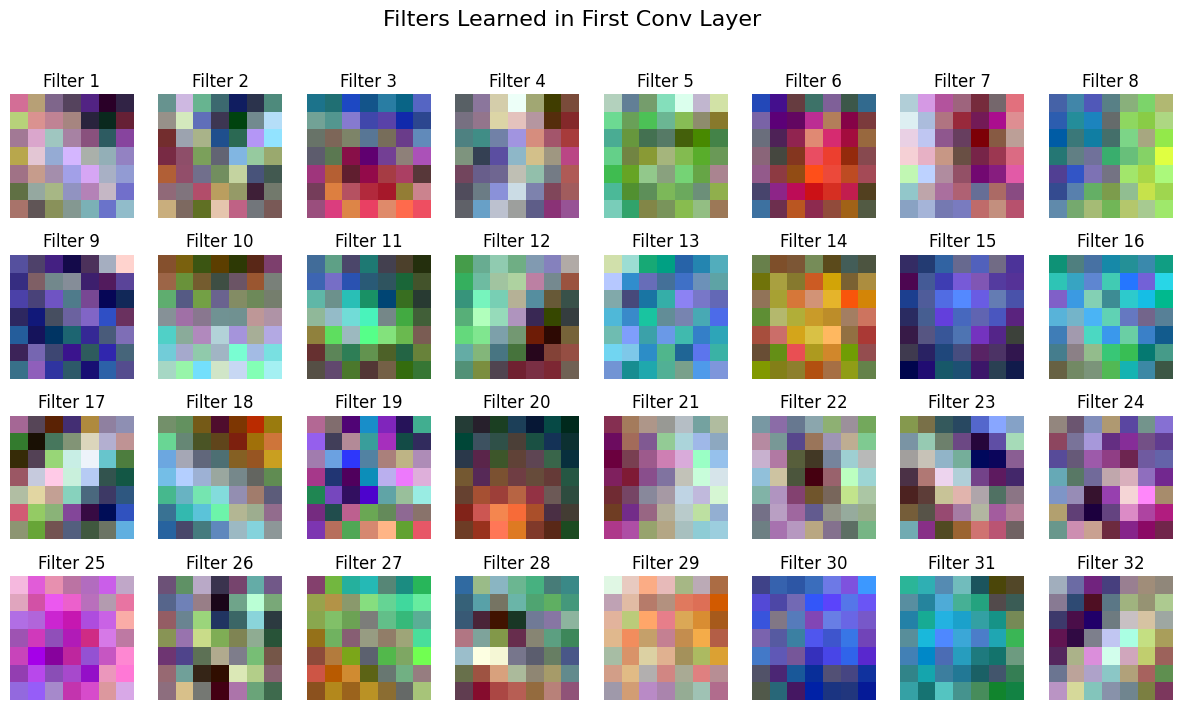

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize filters from the first convolutional layer
def visualize_filters(model):
    # Retrieve the first convolutional layer (Conv1)
    first_conv_layer = model.conv1  # First convolutional layer
    filters = first_conv_layer.weight.data.cpu().numpy()  # Convert filters to a NumPy array

    num_filters = filters.shape[0]  # Number of filters
    fig, axes = plt.subplots(4, min(8, num_filters), figsize=(15, 8))  # 4 rows, up to 8 filters per row

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            # RGB filter (3 channels)
            f_min, f_max = filters[i].min(), filters[i].max()
            filter_normalized = (filters[i] - f_min) / (f_max - f_min)  # Normalize for visualization

            ax.imshow(np.transpose(filter_normalized, (1, 2, 0)))  # Display the filter
            ax.axis('off')
            ax.set_title(f'Filter {i+1}')

    plt.suptitle("Filters Learned in First Conv Layer", fontsize=16)
    plt.show()

# Display the filters of the model
visualize_filters(model_ResNet_Architecture)


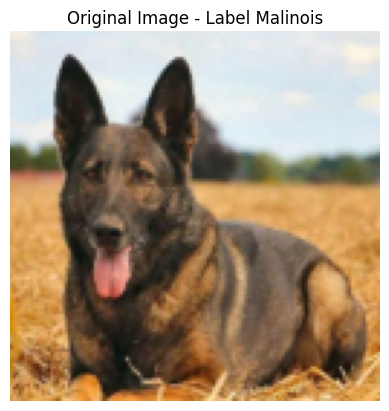

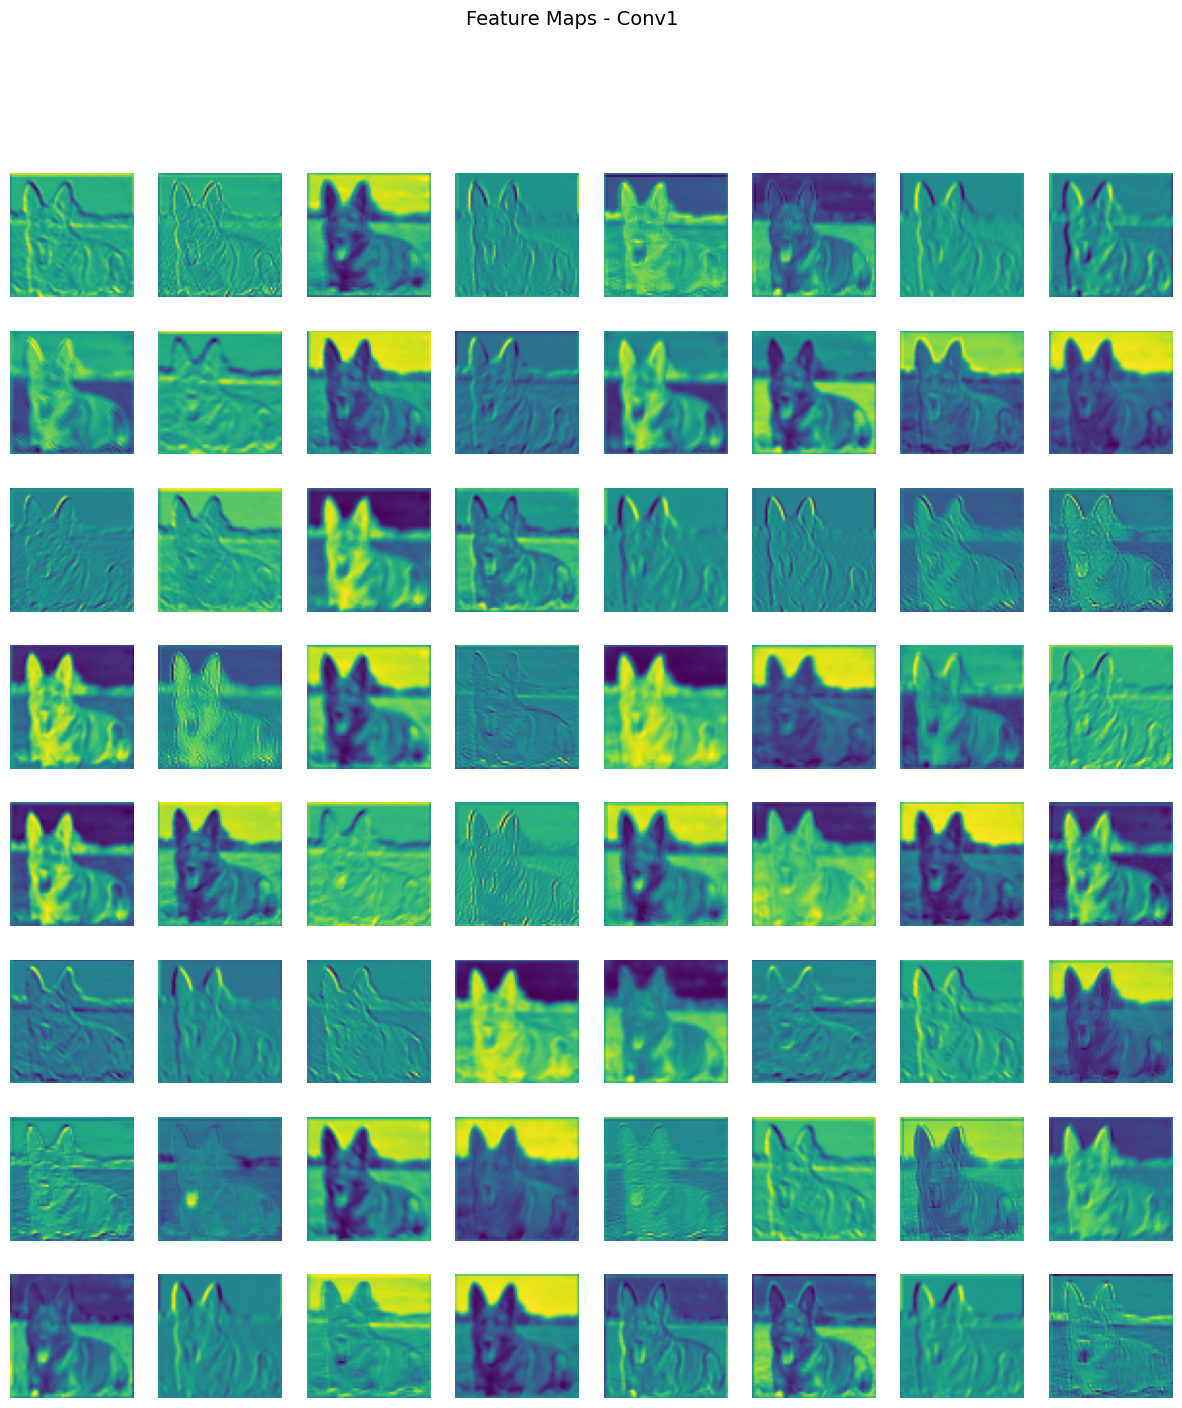

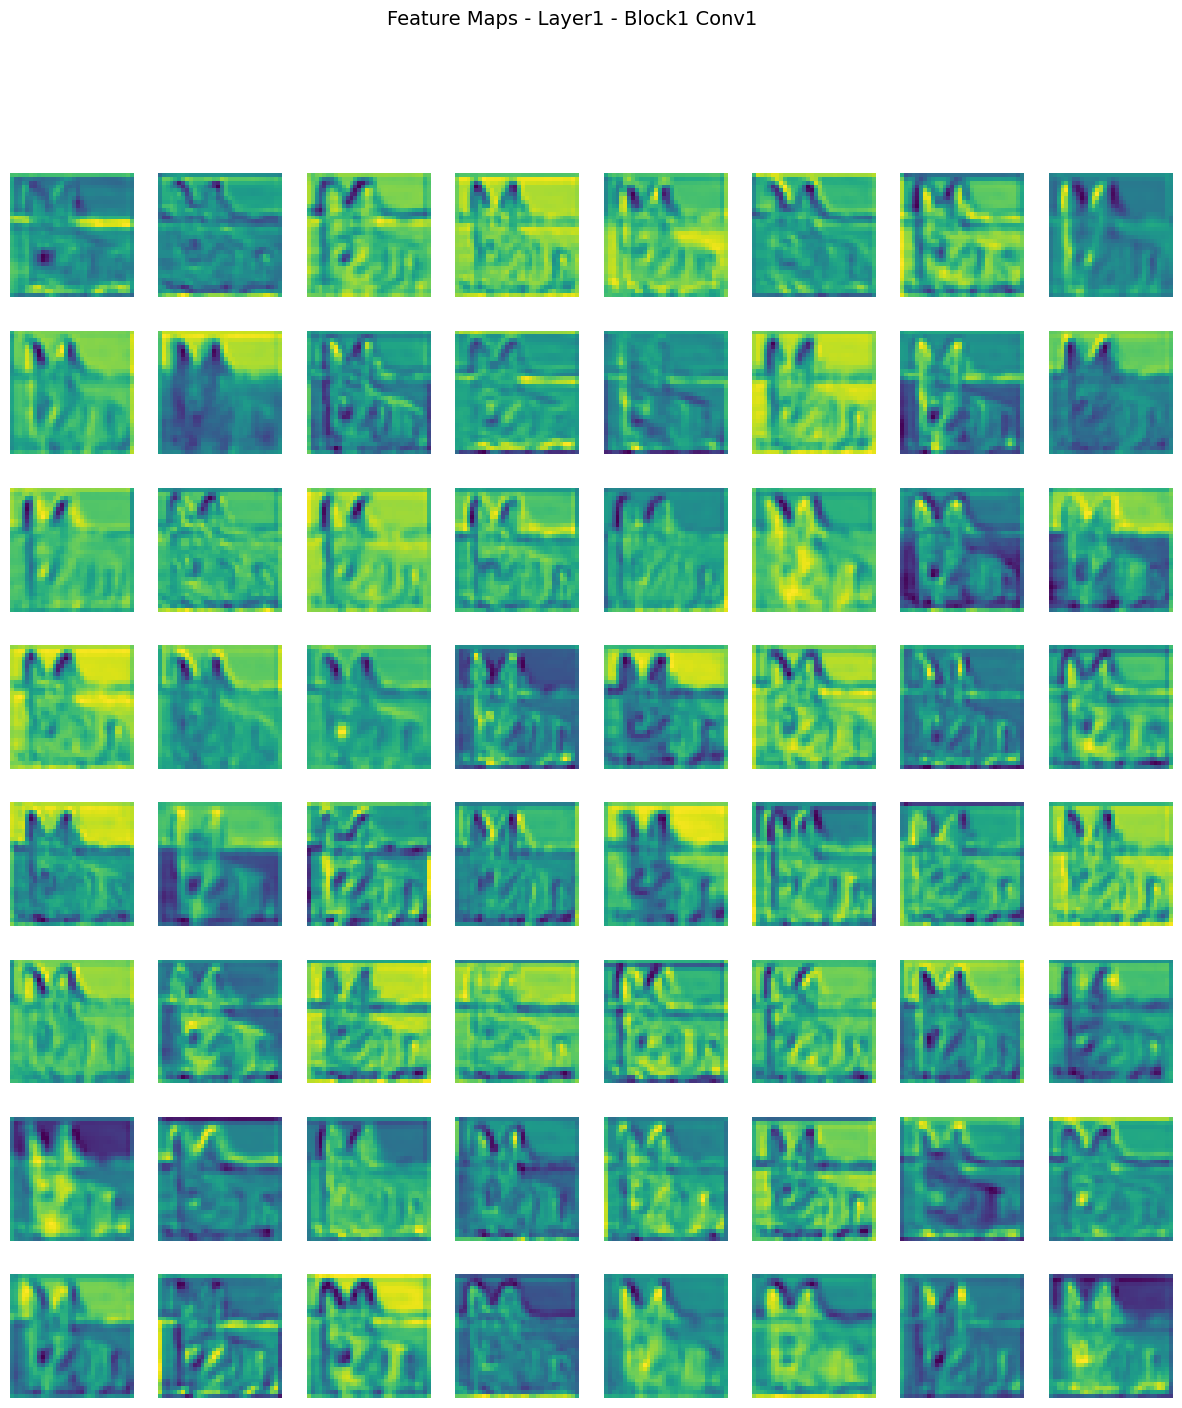

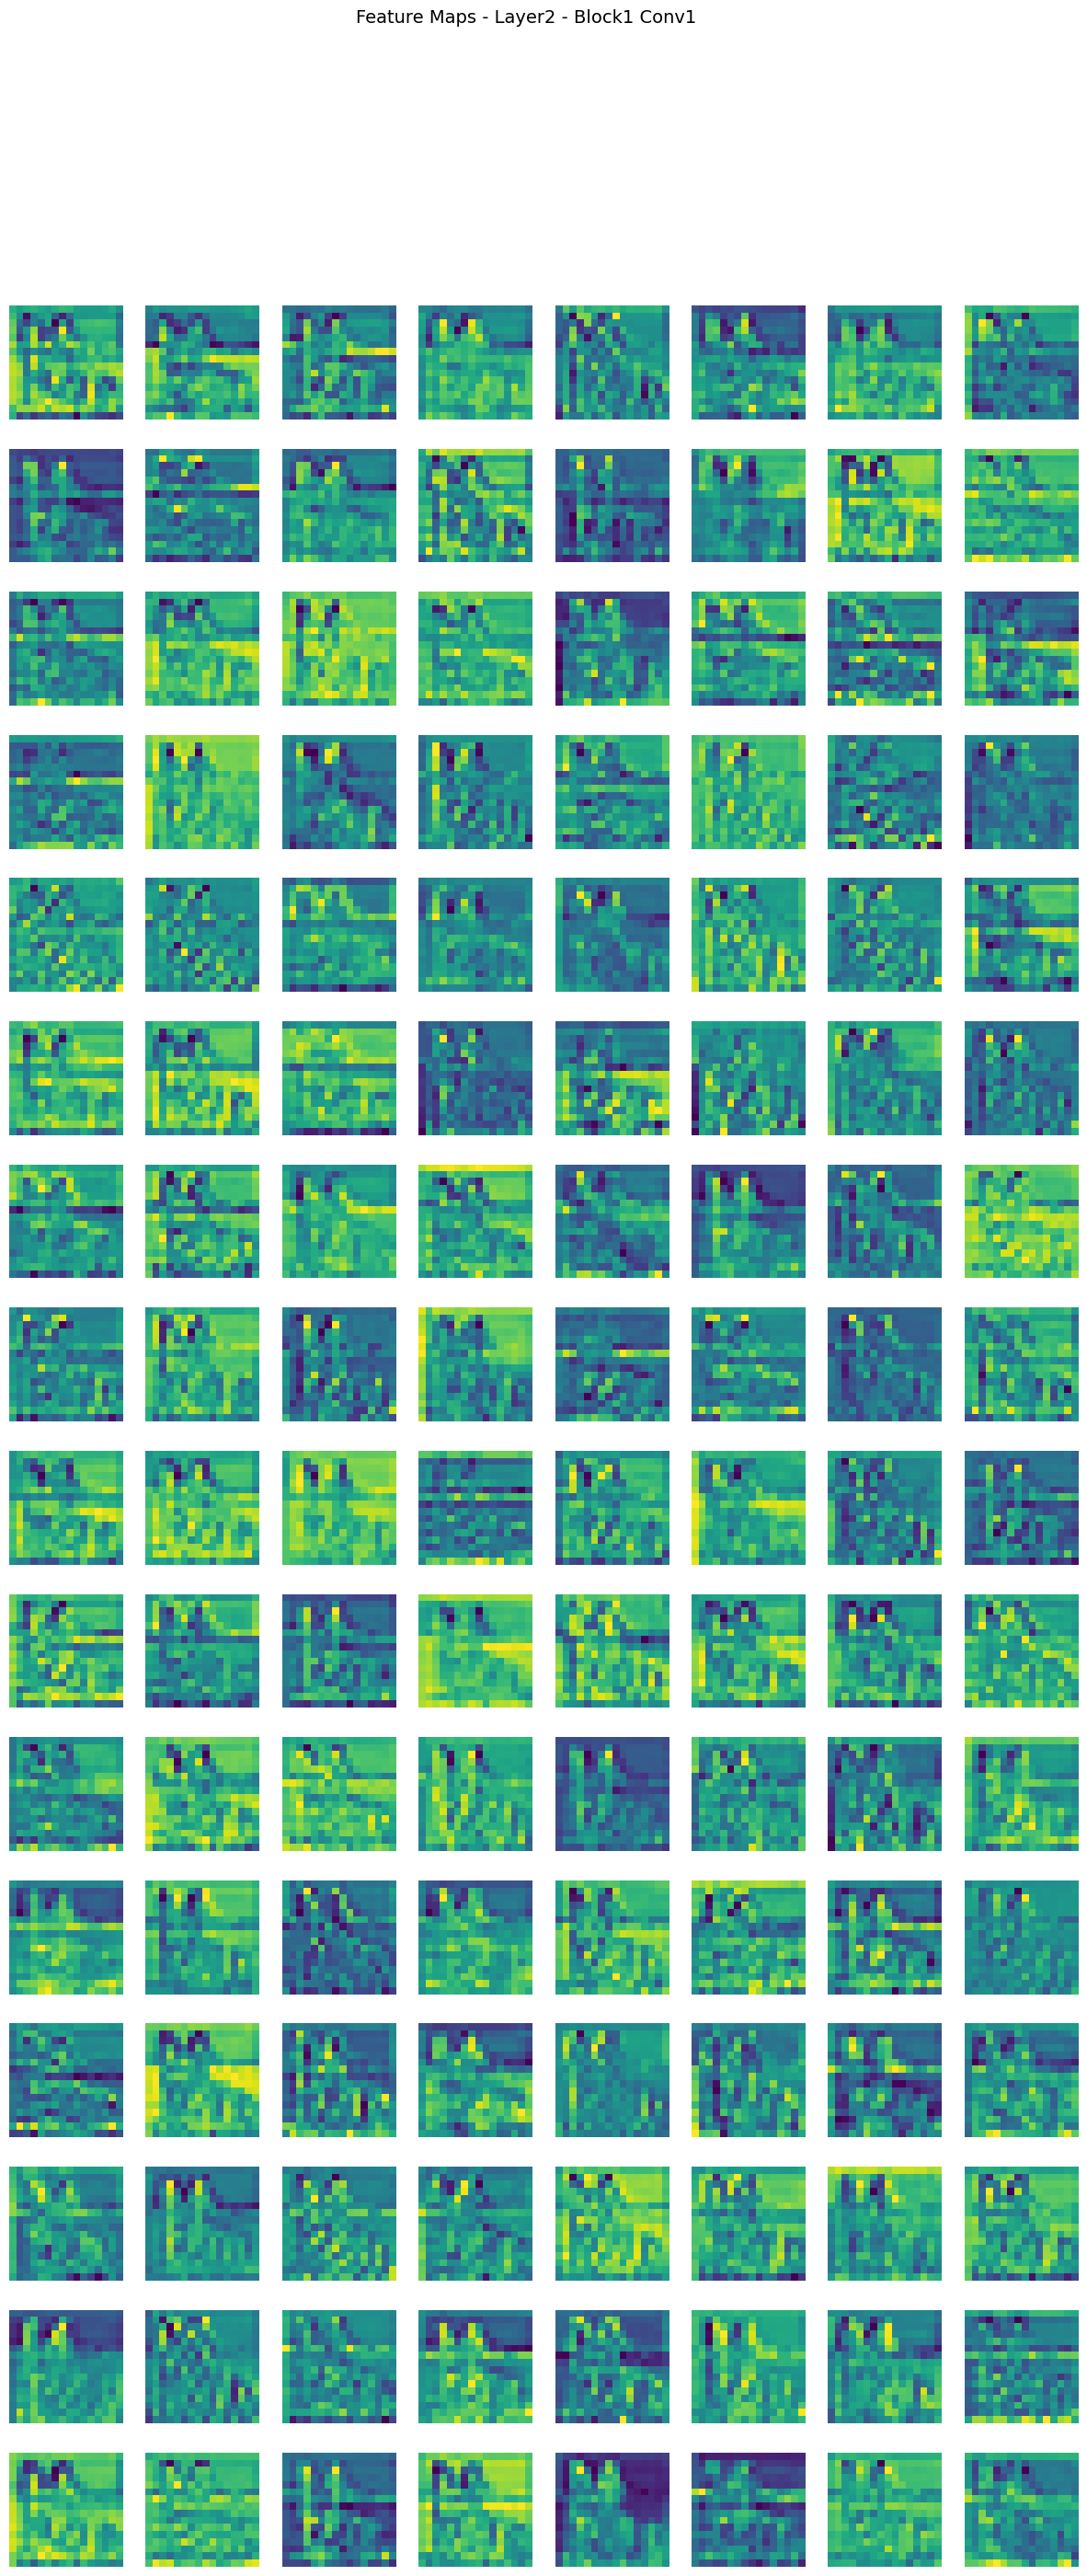

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import random

# Select a random image from the dataset
def get_random_image_from_dataset(dataset):
    index = random.randint(0, len(dataset) - 1)  # Select a random index
    image, label = dataset[index]
    return image, label

# Function to extract feature maps from specific layers
def get_feature_maps(model, image_tensor, layers_to_visualize):
    model.eval()
    outputs = []
    hooks = []

    # Hook function to store the output of selected layers
    def hook_fn(module, input, output):
        outputs.append(output.cpu().detach())

    # Attach hooks to the selected layers
    for layer in layers_to_visualize:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Pass the image through the model
    with torch.no_grad():
        model(image_tensor.unsqueeze(0).to(device))  # Add batch dimension

    # Remove hooks after extracting feature maps
    for hook in hooks:
        hook.remove()

    return outputs

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, layer_names, num_columns=8):
    for i, fmap in enumerate(feature_maps):
        fmap = fmap.squeeze(0)  # Remove batch dimension
        num_filters = fmap.shape[0]

        num_rows = int(np.ceil(num_filters / num_columns))  # Calculate number of rows
        fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 2 * num_rows))

        for j, ax in enumerate(axes.flat):
            if j < num_filters:
                ax.imshow(fmap[j], cmap='viridis')
            ax.axis('off')

        plt.suptitle(f"Feature Maps - {layer_names[i]}", fontsize=14)
        plt.show()

# Select a random image from the test dataset
sample_image, sample_label = get_random_image_from_dataset(test_data)

# Display the original image
plt.imshow(sample_image.permute(1, 2, 0) * 0.5 + 0.5)  # Perform denormalization to restore original colors
plt.title(f"Original Image - Label {test_data.classes[sample_label]}")
plt.axis('off')
plt.show()

# Select layers for feature map visualization
layers_to_visualize = [model_ResNet_Architecture.conv1,
                       model_ResNet_Architecture.layer1[0].conv1,
                       model_ResNet_Architecture.layer2[0].conv1]

layer_names = ["Conv1", "Layer1 - Block1 Conv1", "Layer2 - Block1 Conv1"]

# Extract and visualize feature maps
feature_maps = get_feature_maps(model_ResNet_Architecture, sample_image, layers_to_visualize)
visualize_feature_maps(feature_maps, layer_names)
